# Forecasting Australia's 2019 Election with PyMC3

## Overview
https://www.abc.net.au/news/2019-05-19/federal-election-results-how-the-polls-got-it-so-wrong/11128176
* Motivation
* Australian election primer
* Building a model in PyMC3
    - Bayesian parameter estimation
    - Bayesian linear regression
    - Crossbench (homework)
    - Bringing it all together
* Review performance

In [198]:
pwd

'/Users/mtb/Documents/bitbucket/buckleysnone/PyCon2019/notebooks'

## Motivation

## Australian Election's Primer

### 151 seats
To simplify things, let's say the seats can be won by one of three groups:
* Coalition (Liberal and National parties)
* Australian Labor Party
* Crossbench (anyone else)

### Two-party preferred
* Australia has *preferential* voting. This means the "two-party preferred vote" is more important than the "primary vote"


## Building a model in PyMC3

In [115]:
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statistics import mean
import theano.tensor as tt

In [2]:
%matplotlib inline

### Bayesian parameter estimation

#### Look at the data. 

In [174]:
polls = pd.read_csv('../data/polls2019.csv', index_col=0)

In [175]:
polls

,Unnamed: 0.1,start_date,end_date,firm,tpp_alp,tpp_lnc,tpp_margin,next_election,days_to_next,bias,std
0,72,2019-03-07,2019-03-10,newspoll,0.540,0.460,-0.08,2019-05-18,69,-0.030857,0.046359
1,73,2019-03-06,2019-03-11,essential,0.530,0.470,-0.06,2019-05-18,68,-0.032857,0.014508
2,74,2019-03-21,2019-03-25,essential,0.520,0.480,-0.04,2019-05-18,54,-0.047143,0.022446
3,75,2019-03-25,2019-03-28,galaxy,0.530,0.470,-0.06,2019-05-18,51,-0.029667,0.036009
4,76,2019-04-03,2019-04-06,ipsos,0.530,0.470,-0.06,2019-05-18,42,-0.008000,0.017889
5,77,2019-04-04,2019-04-07,essential,0.520,0.480,-0.04,2019-05-18,41,-0.046250,0.033354
6,78,2019-04-04,2019-04-07,newspoll,0.520,0.480,-0.04,2019-05-18,41,-0.038800,0.063807
7,79,2019-04-06,2019-04-07,morgan,0.525,0.475,-0.05,2019-05-18,41,-0.084053,0.040027
8,80,2019-04-11,2019-04-14,newspoll,0.520,0.480,-0.04,2019-05-18,34,-0.018222,0.063564
9,81,2019-04-20,2019-04-21,morgan,0.510,0.490,-0.02,2019-05-18,27,-0.042167,0.095155


* tpp_margin = two-party preferred margin reported by the poll
* bias = an estimate of how "biased" this poll is. It is estimated by averaging the accuracy of polls by the same pollster a similar number of days out from an election (days_to_election)
* std = an estimate of the standard deviation of this poll. This is calculated using the same polls as the bias calculation. The smaller the standard deviation the more this poll will move the forecast. 

In [173]:
pwd

'/Users/mtb/Documents/bitbucket/buckleysnone/PyCon2019/notebooks'

In [176]:
polls['tpp_adjusted'] = polls['tpp_margin'] -  polls['bias']

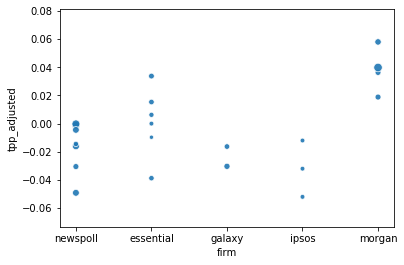

In [6]:
_ = sns.scatterplot(x='firm', y='tpp_adjusted', size='std', alpha=0.9, legend=False,data=polls)

#### Specify a prior.

In [70]:
with pm.Model() as tpp_model: # explain "with"
    tpp_margin = pm.Uniform('tpp_margin', lower=-1, upper=1)
    trace = pm.sample(draws=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tpp_margin]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2633.46draws/s]


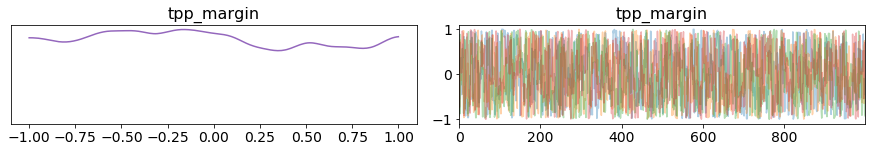

In [71]:
_ = pm.traceplot(trace, combined=True, compact=False)

_Notes_:
- This is a probability density function.
- Along the x-axis are all the possible values of the two-party preferred margin. 
- The y-axis represents the relative probability of the different values
- You can see here that all values from -1 to 1 have similar probabilities because we haven't included any data in the model yet.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tpp_margin]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3077.14draws/s]


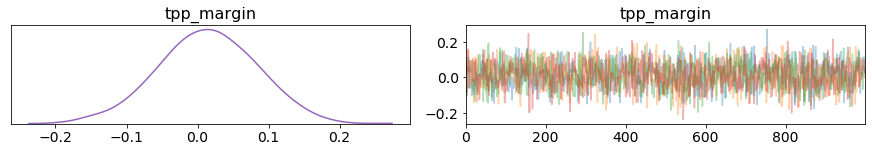

In [72]:
with pm.Model() as tpp_model: # explain "with"
    tpp_margin = pm.Normal('tpp_margin', mu=0.015, sigma=0.07)
    trace = pm.sample(draws=1000, cores=4)
_ = pm.traceplot(trace, combined=True, compact=False)

#### We can ask some questions of this prior, before our model has seen any data. 
What is the probability the Coaltion win the two-party preferred vote?

In [73]:
print("Coalition win: {:.1f}%".format((trace['tpp_margin'] > 0).mean()*100))

Coalition win: 57.6%


In [74]:
print("Labor win: {:.1f}%".format((trace['tpp_margin'] < 0).mean()*100))

Labor win: 42.4%


With more samples these would approach 50/50

#### Specify a likelihood.

In [75]:
with tpp_model:
    tpp_likelihood = pm.Normal('tpp_likelihood', tpp_margin, sd = polls['std'], observed = polls['tpp_adjusted'])
    # tpp_margin refers to the random variable we specified above
    trace = pm.sample(draws=1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tpp_margin]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:02<00:00, 3163.14draws/s]


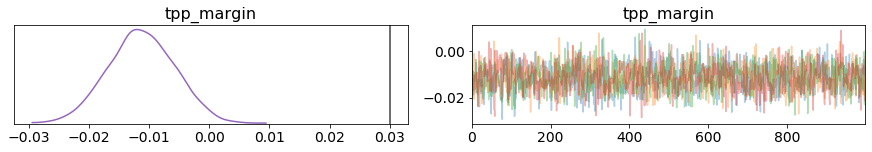

In [76]:
_ = pm.traceplot(trace,combined=True,  var_names = ['tpp_margin'], lines=[('tpp_margin', {}, [0.03])])

* I've noted the actual result from the election: the Coalition winning with a margin of 3% (51.5% to 48.5%)
* You can see our estimate doesn't give any probability to the actual two-party preferred outcome
* I'll discuss this a little more later but it mostly reflects the inaccuracies of polling
* This gives an idea of what we predict the two-party preferred vote will be, can we still use it to predict the number of seats each party will win at an election?

### Bayesian linear regression

#### Look at the data.

In [137]:
pe = pd.read_csv('../../buckleys_model/data/processed/election_data.csv')

In [139]:
cp ../../buckleys_model/data/processed/election_data.csv ../data/election_data.csv

In [140]:
past_elections = pd.read_csv('../data/election_data.csv', index_col='date')

In [141]:
past_elections = past_elections.tail(22)

In [142]:
past_elections

,primary_alp,primary_lnc,primary_oth,tpp_alp,tpp_lnc,seats_alp,seats_lnc,seats_oth,seats_total,seat_pc_alp,...,tpp_swing_lnc,tpp_swing_alp,seat_swing_lnp,seat_swing_alp,seat_swing_lnp_pc,seat_swing_alp_pc,tpp_margin,seat_margin,seat_margin_pc,seat_margin_pc_majors
date,,,,,,,,,,,,,,,,,,,,,
1963-11-30,0.455,0.460,0.085,0.474,0.526,50.0,72.0,0.0,122.0,0.409836,...,0.031,-0.031,10.0,-10.0,0.081967,-0.081967,0.052,22.0,0.180328,0.180328
1966-11-26,0.400,0.500,0.100,0.431,0.569,41.0,82.0,1.0,124.0,0.330645,...,0.043,-0.043,10.0,-9.0,0.071126,-0.079191,0.138,41.0,0.330645,0.333333
1969-10-25,0.470,0.433,0.097,0.502,0.498,59.0,66.0,0.0,125.0,0.472000,...,-0.071,0.071,-16.0,18.0,-0.133290,0.141355,-0.004,7.0,0.056000,0.056000
1972-12-02,0.496,0.415,0.089,0.527,0.473,67.0,58.0,0.0,125.0,0.536000,...,-0.025,0.025,-8.0,8.0,-0.064000,0.064000,-0.054,-9.0,-0.072000,-0.072000
1974-05-18,0.493,0.449,0.058,0.517,0.483,66.0,61.0,0.0,127.0,0.519685,...,0.010,-0.010,3.0,-1.0,0.016315,-0.016315,-0.034,-5.0,-0.039370,-0.039370
1975-12-13,0.428,0.531,0.041,0.443,0.557,36.0,91.0,0.0,127.0,0.283465,...,0.074,-0.074,30.0,-30.0,0.236220,-0.236220,0.114,55.0,0.433071,0.433071
1977-12-10,0.397,0.481,0.122,0.454,0.546,38.0,86.0,0.0,124.0,0.306452,...,-0.011,0.011,-5.0,2.0,-0.022987,0.022987,0.092,48.0,0.387097,0.387097
1980-10-18,0.452,0.463,0.085,0.496,0.504,51.0,74.0,0.0,125.0,0.408000,...,-0.042,0.042,-12.0,13.0,-0.101548,0.101548,0.008,23.0,0.184000,0.184000
1983-03-05,0.495,0.436,0.069,0.532,0.468,75.0,50.0,0.0,125.0,0.600000,...,-0.036,0.036,-24.0,24.0,-0.192000,0.192000,-0.064,-25.0,-0.200000,-0.200000


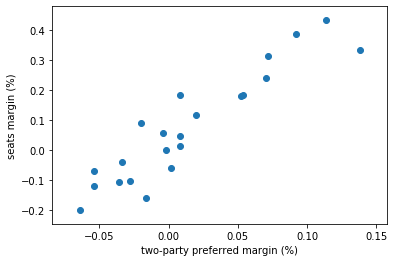

In [143]:
_ = plt.scatter(past_elections['tpp_margin'], past_elections['seat_margin_pc_majors'])
_ = plt.xlabel("two-party preferred margin (%)")
_ = plt.ylabel("seats margin (%)")

_Have you seen something more linear?!?_

y = slope * x + intercept + error

In [144]:
model = sm.OLS(past_elections['seat_margin_pc_majors'], sm.add_constant(past_elections['tpp_margin']))

/Users/mtb/miniconda3/envs/pycon2019/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [80]:
results = model.fit()

In [82]:
results.
# results.ssr

,0,1
const,0.027615,0.076475
tpp_margin,2.643622,3.344058


In [44]:
results.ssr

0.18919118908015592

In [28]:
lobf_slope, lobf_intercept = best_fit_slope_and_intercept(past_elections['tpp_margin'], past_elections['seat_margin_pc_majors'])

In [29]:
lobf_slope, lobf_intercept

(2.9938400779320475, 0.052045005323868646)

In [30]:
lobf_x = pd.DataFrame([past_elections['tpp_margin'].min(), past_elections['tpp_margin'].max()])
lobf_y = lobf_x * lobf_slope + lobf_intercept

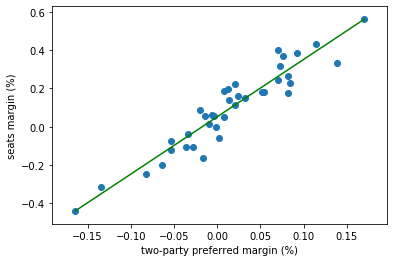

In [45]:
_ = plt.scatter(past_elections['tpp_margin'], past_elections['seat_margin_pc_majors'])
_ = plt.plot(lobf_x, lobf_y, color='green')
_ = plt.xlabel("two-party preferred margin (%)")
_ = plt.ylabel("seats margin (%)")

#### Specify priors.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2252.59draws/s]


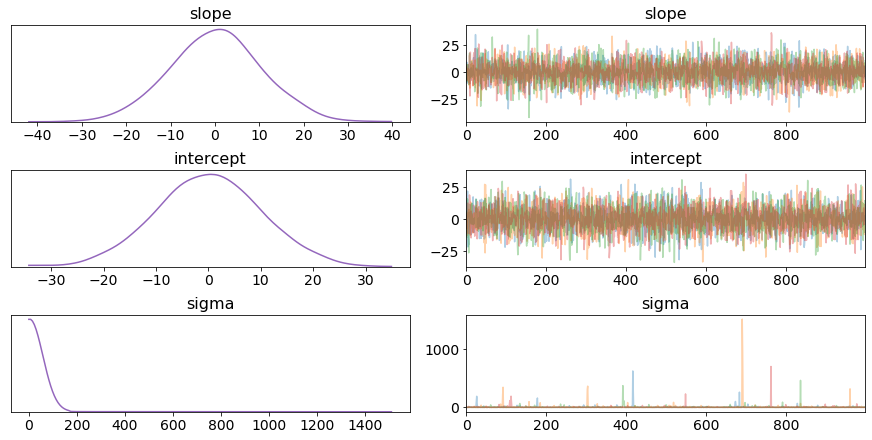

In [83]:
with pm.Model() as linreg_model:
    slope = pm.Normal('slope', 0, sd=10)
    intercept = pm.Normal('intercept', 0, sd=10)
    sigma = pm.HalfCauchy('sigma', 1)
    trace = pm.sample(draws=1000, cores=4)
_ = pm.traceplot(trace, combined=True)

#### Specify likelihood.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:03<00:00, 1914.18draws/s]


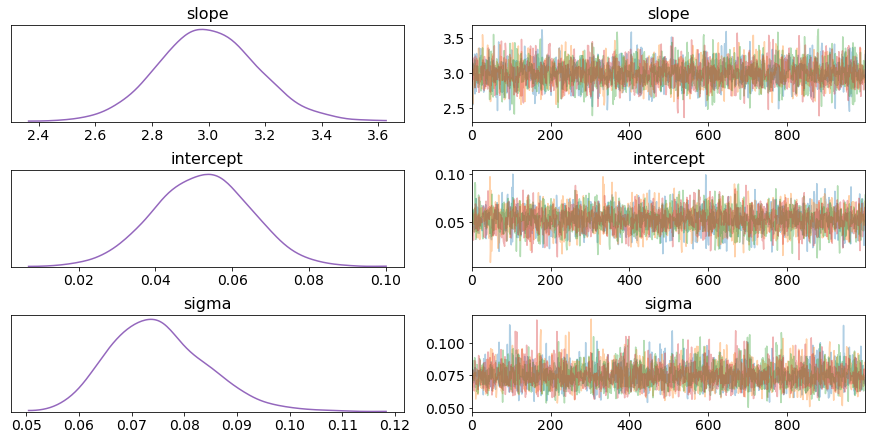

In [84]:
with linreg_model:
    y = intercept + slope * past_elections['tpp_margin']

    # tpp2seat likelihood
    tpp2seat_like = pm.Normal('linreg_likelihood', y, sd = sigma, observed = past_elections['seat_margin_pc_majors'])
    trace = pm.sample(draws=1000, cores=4)
_ = pm.traceplot(trace, combined=True)

In [85]:
df = pm.trace_to_dataframe(trace)

In [86]:
df['slope'].describe()
df['intercept'].describe()

count    4000.000000
mean        0.051971
std         0.012513
min         0.006959
25%         0.043480
50%         0.052218
75%         0.060216
max         0.100132
Name: intercept, dtype: float64

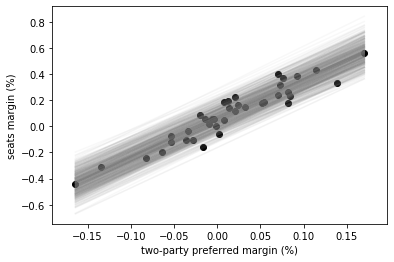

In [88]:
_ = plt.scatter(past_elections['tpp_margin'], past_elections['seat_margin_pc_majors'], color='black', zorder=0)

for i in range(500):
    line_x = pd.DataFrame([past_elections['tpp_margin'].min(), past_elections['tpp_margin'].max()])
    line_y = line_x * df.loc[i,'slope'] + df.loc[i,'intercept'] + np.random.normal(loc=0.0, scale=df.loc[i,'sigma'])
    _ = plt.plot(line_x, line_y, color='grey', alpha=0.05, zorder=i+1)
_ = plt.xlabel("two-party preferred margin (%)")
_ = plt.ylabel("seats margin (%)")

### Crossbench

In [177]:
crossbench_stats = pd.read_csv('../data/crossbench_stats.csv', index_col=0)
with pm.Model() as all_together:
    p_retain = pm.Beta('p_retain', alpha=1, beta=1)
    crossbench_retain_like = pm.Binomial('crossbench_retain_like', n=crossbench_stats['crossbench_running'], p=p_retain, observed=crossbench_stats['crossbench_retain'])
    crossbench_retain = pm.Binomial('crossbench_retain', n=6, p=p_retain)

    p_gain = pm.Beta('p_gain', alpha=1, beta=1)
    crossbench_gain_like = pm.Binomial('crossbench_gain_like', n=crossbench_stats['gain_opportunities'], p=p_gain, observed=crossbench_stats['crossbench_gain'])
    crossbench_gain = pm.Binomial('crossbench_gain', n=145, p=p_gain)

    crossbench_total = pm.Deterministic('crossbench_total', crossbench_gain + crossbench_retain)
#     trace = pm.sample(draws=1000, cores=4)
# _ = pm.traceplot(trace, combined=True,var_names=['crossbench_total'])

### Putting it all together

In [178]:
with all_together:
    #estimate tpp_margin
    tpp_margin = pm.Uniform('tpp_margin', lower=-1, upper=1) #prior
    errors = polls['tpp_margin'].values - tpp_margin

            # tpp_margin likelihood
    tpp_margin_like = pm.Normal('tpp_margin_like', errors, sd = polls['std'], observed = polls['bias'])
#     tpp_likelihood = pm.Normal('tpp_likelihood', tpp_margin, sd = polls['std'], observed = polls['tpp_adjusted']) #likelihood

    #estimate linear relationship between tpp_margin and seat_margin
    slope = pm.Normal('slope', 0, sd=10) #prior
    intercept = pm.Normal('intercept', 0, sd=10) #prior
    sigma = pm.HalfCauchy('sigma', 1) #prior
    y = intercept + slope * past_elections['tpp_margin'] #define relationship
    tpp2seat_like = pm.Normal('linreg_likelihood', y, sd = sigma, observed = past_elections['seat_margin_pc_majors']) #likelihood
    
    # estimate seat_margin
    seat_margin_pc = pm.Normal('seat_margin_pc', intercept + slope * tpp_margin, sd = sigma) #combine estimates
    
    majors_seats = (151.0 - crossbench_total)
    seat_margin_temp = majors_seats * seat_margin_pc
    alp_seats = pm.Deterministic('alp_seats', tt.round((majors_seats/2.0) - (seat_margin_temp/2.0)).astype('int8'))
    lnc_seats = pm.Deterministic('lnc_seats', tt.round((majors_seats/2.0) + (seat_margin_temp/2.0)).astype('int8'))

    majors_seat_margin = pm.Deterministic('majors_seat_margin', lnc_seats - alp_seats)
    trace = pm.sample(draws=5000,tune=1000, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [seat_margin_pc, sigma, intercept, slope, tpp_margin, p_gain, p_retain]
>CompoundStep
>>Metropolis: [crossbench_gain]
>>Metropolis: [crossbench_retain]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:49<00:00, 482.75draws/s]
The number of effective samples is smaller than 25% for some parameters.


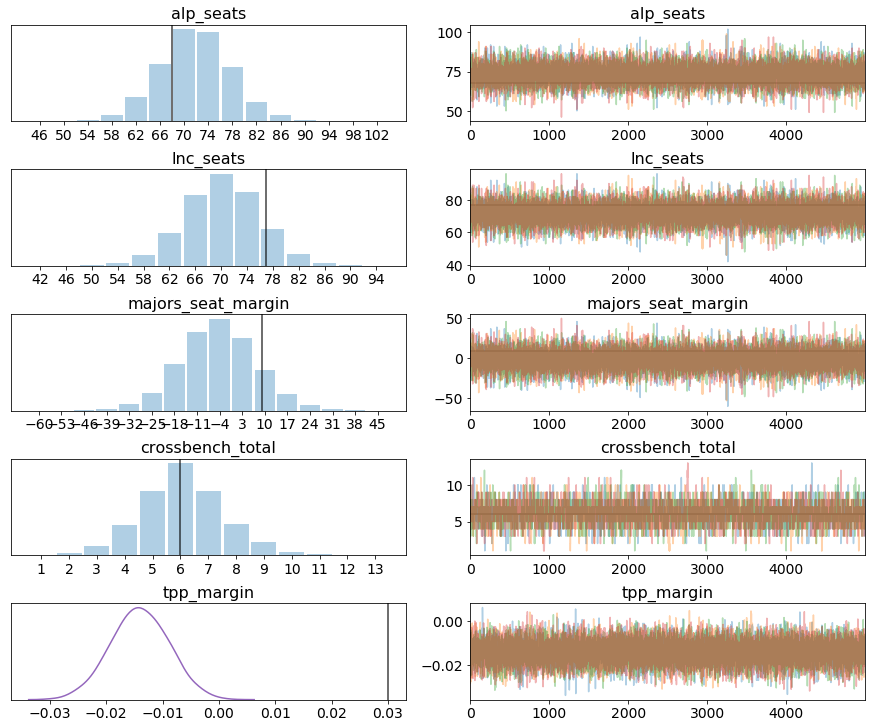

In [197]:
_ = pm.traceplot(trace, combined=True, var_names=['alp_seats', 'lnc_seats', 'majors_seat_margin', 'crossbench_total', 'tpp_margin'], lines=[('alp_seats', {}, [68]), ('lnc_seats', {}, [77]), ('majors_seat_margin', {}, [9]), ('crossbench_total', {}, [6]), ('tpp_margin', {}, [0.03])])

In [186]:
(49.29 - 50.71)/100

-0.014200000000000016